
# <span style="color:rgb(0,0,0)">Tutoriel UNLocBoX 1 : Régression Sparse (LASSO)</span>

# <span style="color:rgb(0,0,0)">Objectif : Résoudre le problème LASSO (Least Absolute Shrinkage and Selection Operator). C'est un problème fondamental en analyse convexe pour trouver des solutions \*éparses\* (avec beaucoup de zéros) à des systèmes linéaires.</span>

# <span style="color:rgb(0,0,0)"> Le Problème Mathématique</span>

# <span style="color:rgb(0,0,0)">Nous cherchons à résoudre :</span>

# <span style="color:rgb(0,0,0)">\$\$x^\* = \\arg \\min\_x \\frac{1}{2} ||Ax\-y||\_2^2 + \\lambda ||x||\_1\$\$</span>

# <span style="color:rgb(0,0,0)"> Analyse Convexe</span>

# <span style="color:rgb(0,0,0)">Ce problème est la somme de deux fonctions convexes :</span>

# <span style="color:rgb(0,0,0)">1.  \$f_1(x) = \\frac{1}{2} ||Ax-y||_2^2\$ : Un terme de fidélité aux données. Il est convexe et différentiable (lisse).</span>

# <span style="color:rgb(0,0,0)">2.  \$f_2(x) = \\lambda ||x||_1\$ : Un terme de régularisation \$l_1\$. Il est convexe mais non\-différentiable (à 0) et favorise la parcimonie.</span>

# <span style="color:rgb(0,0,0)">Nous allons donc définir une structure `f1` (lisse) et `f2` (non\-lisse). UNLocBoX choisira automatiquement le solveur `forward_backward` (FISTA).</span>

In [1]:
% === 1. Initialisation ===
clear;
clc;
close all;

% Indiquez à MATLAB où se trouve la toolbox
% Voici le chemin que vous avez fourni :
chemin_unlocbox = '/home/thekan/Téléchargements/unlocbox-1.7.5';

% Cette ligne ajoute le dossier ET tous ses sous-dossiers au chemin
addpath(genpath(chemin_unlocbox));

init_unlocbox();

UnLocBoX version 1.7.5. Copyright 2012-2015 LTS2-EPFL, by Nathanael Perraudin

In [2]:

disp('UNLocBoX initialisée avec succès.');

UNLocBoX initialisée avec succès.

### 2. Génération des Données

Nous allons créer un problème synthétique :
* `x_vrai` : Un signal "sparse" (avec 5 pics non nuls) de dimension $N=100$.
* `A` : Une matrice de mesure aléatoire de dimension $M=50, N=100$.
* `y` : Les mesures, $y = A \cdot x_{vrai} + \text{bruit}$.

In [3]:
% === 2. Génération des données ===

% Dimensions du problème
M = 50;  % Nombre de mesures
N = 100; % Dimension du signal (pb sous-déterminé)

% Création du signal sparse original (avec 5 pics)
x_vrai = zeros(N, 1);
indices = randperm(N, 5);
x_vrai(indices) = randn(5, 1) * 10;

% Création de la matrice de mesure A
A = randn(M, N);
A = A ./ sqrt(sum(A.^2, 1)); % Normalisation des colonnes

% Création des mesures bruitées y
sigma_bruit = 0.1;
y = A * x_vrai + sigma_bruit * randn(M, 1);

disp('Données générées.');

Données générées.


 3. Définition du Problème pour UNLocBoX


Nous traduisons nos fonctions \$f_1\$ et \$f_2\$ en structures MATLAB.


\*\*Paramètre de régularisation :\*\*


On fixe l'importance \$\\lambda\$ de la parcimonie.


In [4]:
% Paramètre de régularisation (poids de la norme L1)
lambda = 0.5;


 Fonction 1 : \$f_1(x) = \\frac{1}{2} ||Ax-y||_2^2\$ (Lisse)


Pour une fonction lisse, nous devons fournir son gradient `f1.grad` et une borne sur la constante de Lipschitz du gradient `f1.beta`.


\* Gradient : \$\\nabla f_1(x) = A^T (Ax - y)\$


\* Constante (borne) : \$\\beta = ||A||_2^2\$


In [5]:
% ----- f1 : Terme de fidélité (Lisse) -----
f1.eval = @(x) 0.5 * norm(A*x - y)^2;
f1.grad = @(x) A' * (A*x - y);
f1.beta = norm(A)^2;

disp('f1 (lisse) définie.');

f1 (lisse) définie.


 Fonction 2 : \$f_2(x) = \\lambda ||x||_1\$ (Non\-lisse)


Pour une fonction non\-lisse, nous devons fournir son opérateur proximal `f2.prox`.


\* Proximal : \$\\text{prox}_{\\gamma f_2}(x) = \\text{prox}_{\\gamma \\lambda ||.||_1}(x)\$


\* UNLocBoX fournit `prox_l1(x, T)`. Nous l'appelons avec \$T = \\lambda \\gamma\$ (où \$\\gamma\$ est le pas de temps, géré par le solveur et passé comme argument `T`).


In [6]:
% ----- f2 : Terme de régularisation (Non-lisse) -----
f2.eval = @(x) lambda * norm(x, 1);
f2.prox = @(x, T) prox_l1(x, lambda * T);

disp('f2 (non-lisse) définie.');

f2 (non-lisse) définie.


 4. Résolution du Problème


Nous appelons `solvep` avec notre point de départ \$x_0 = 0\$.


In [7]:
% === 4. Résolution du Problème ===
x0 = zeros(N, 1); % Point de départ

param.maxit = 200;
param.tol = 1e-6;
param.verbose = 1;

[x_solution, info] = solvep(x0, {f1, f2}, param);

  prox_L1: ||A x-y||_1 = 2.745918e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.564186e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 4.097473e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 4.403391e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 4.517506e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 4.510484e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 4.433090e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 4.295344e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 4.126886e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.952040e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.769389e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.569346e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.387613e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.230588e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.101016e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.046380e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.041123e+00, REL_OB, iter = 2
  prox_L1: ||A x-y||_1 = 3.069949e+00, REL_OB, i

In [8]:

disp(['Solution trouvée en ' num2str(info.iter) ' itérations.']);

Solution trouvée en 55 itérations.


\#\#\# 5. Affichage des résultats


Comparons le signal original `x_vrai` avec la solution `x_solution`. Le graphique s'affichera directement dans le Live Script.


In [9]:
% === 5. Affichage des résultats ===
figure;
subplot(2, 1, 1);
stem(x_vrai, 'b-o', 'LineWidth', 1.5, 'MarkerFaceColor', 'b');
title('Signal Original (x_{vrai})');
legend('x_{vrai}');
grid on;

subplot(2, 1, 2);
stem(x_solution, 'r-s', 'LineWidth', 1.5, 'MarkerFaceColor', 'r');
title(['Signal Reconstruit (x_{solution})']);
legend('x_{solution} (LASSO)');
grid on;


 Tutoriel UNLocBoX 2 : Inpainting d'Image par Variation Totale (TV)


\*\*Objectif :\*\* Restaurer une image dont des pixels ont été perdus (Inpainting). Nous utilisons la régularisation par \*\*Variation Totale (TV)\*\* pour préserver les contours.


\#\#\# Le Problème Mathématique


Nous résolvons :


\$\$x^\* = \\arg \\min\_x \\frac{1}{2} ||A(x)\-y||\_2^2 + \\lambda ||x||\_{TV}\$\$


\* \$x\$ : L'image complète que l'on cherche.


\* \$A\$ : Un opérateur de masquage (qui met à 0 les pixels inconnus).


\* \$y\$ : L'image observée (avec des pixels manquants).


\* \$||x||_{TV}\$ : La régularisation par Variation Totale.


\#\#\# Analyse Convexe


1.  \$f_1(x) = \\frac{1}{2} ||A(x)-y||_2^2\$ : Terme de fidélité. \*\*Lisse\*\*.


2.  \$f_2(x) = \\lambda ||x||_{TV}\$ : Terme de régularisation. \*\*Non\-lisse\*\*.


In [10]:
% === 1. Initialisation ===
clear;
clc;
close all;

% Initialiser UNLocBoX
% addpath('CHEMIN/VERS/VOTRE/unlocbox'); % Modifiez ceci
init_unlocbox();

UnLocBoX version 1.7.5. Copyright 2012-2015 LTS2-EPFL, by Nathanael Perraudin

In [11]:
disp('UNLocBoX initialisée.');

UNLocBoX initialisée.


 2. Chargement et Préparation des Données


Nous chargeons une image de test et créons un masque pour simuler la perte de 50% des pixels.



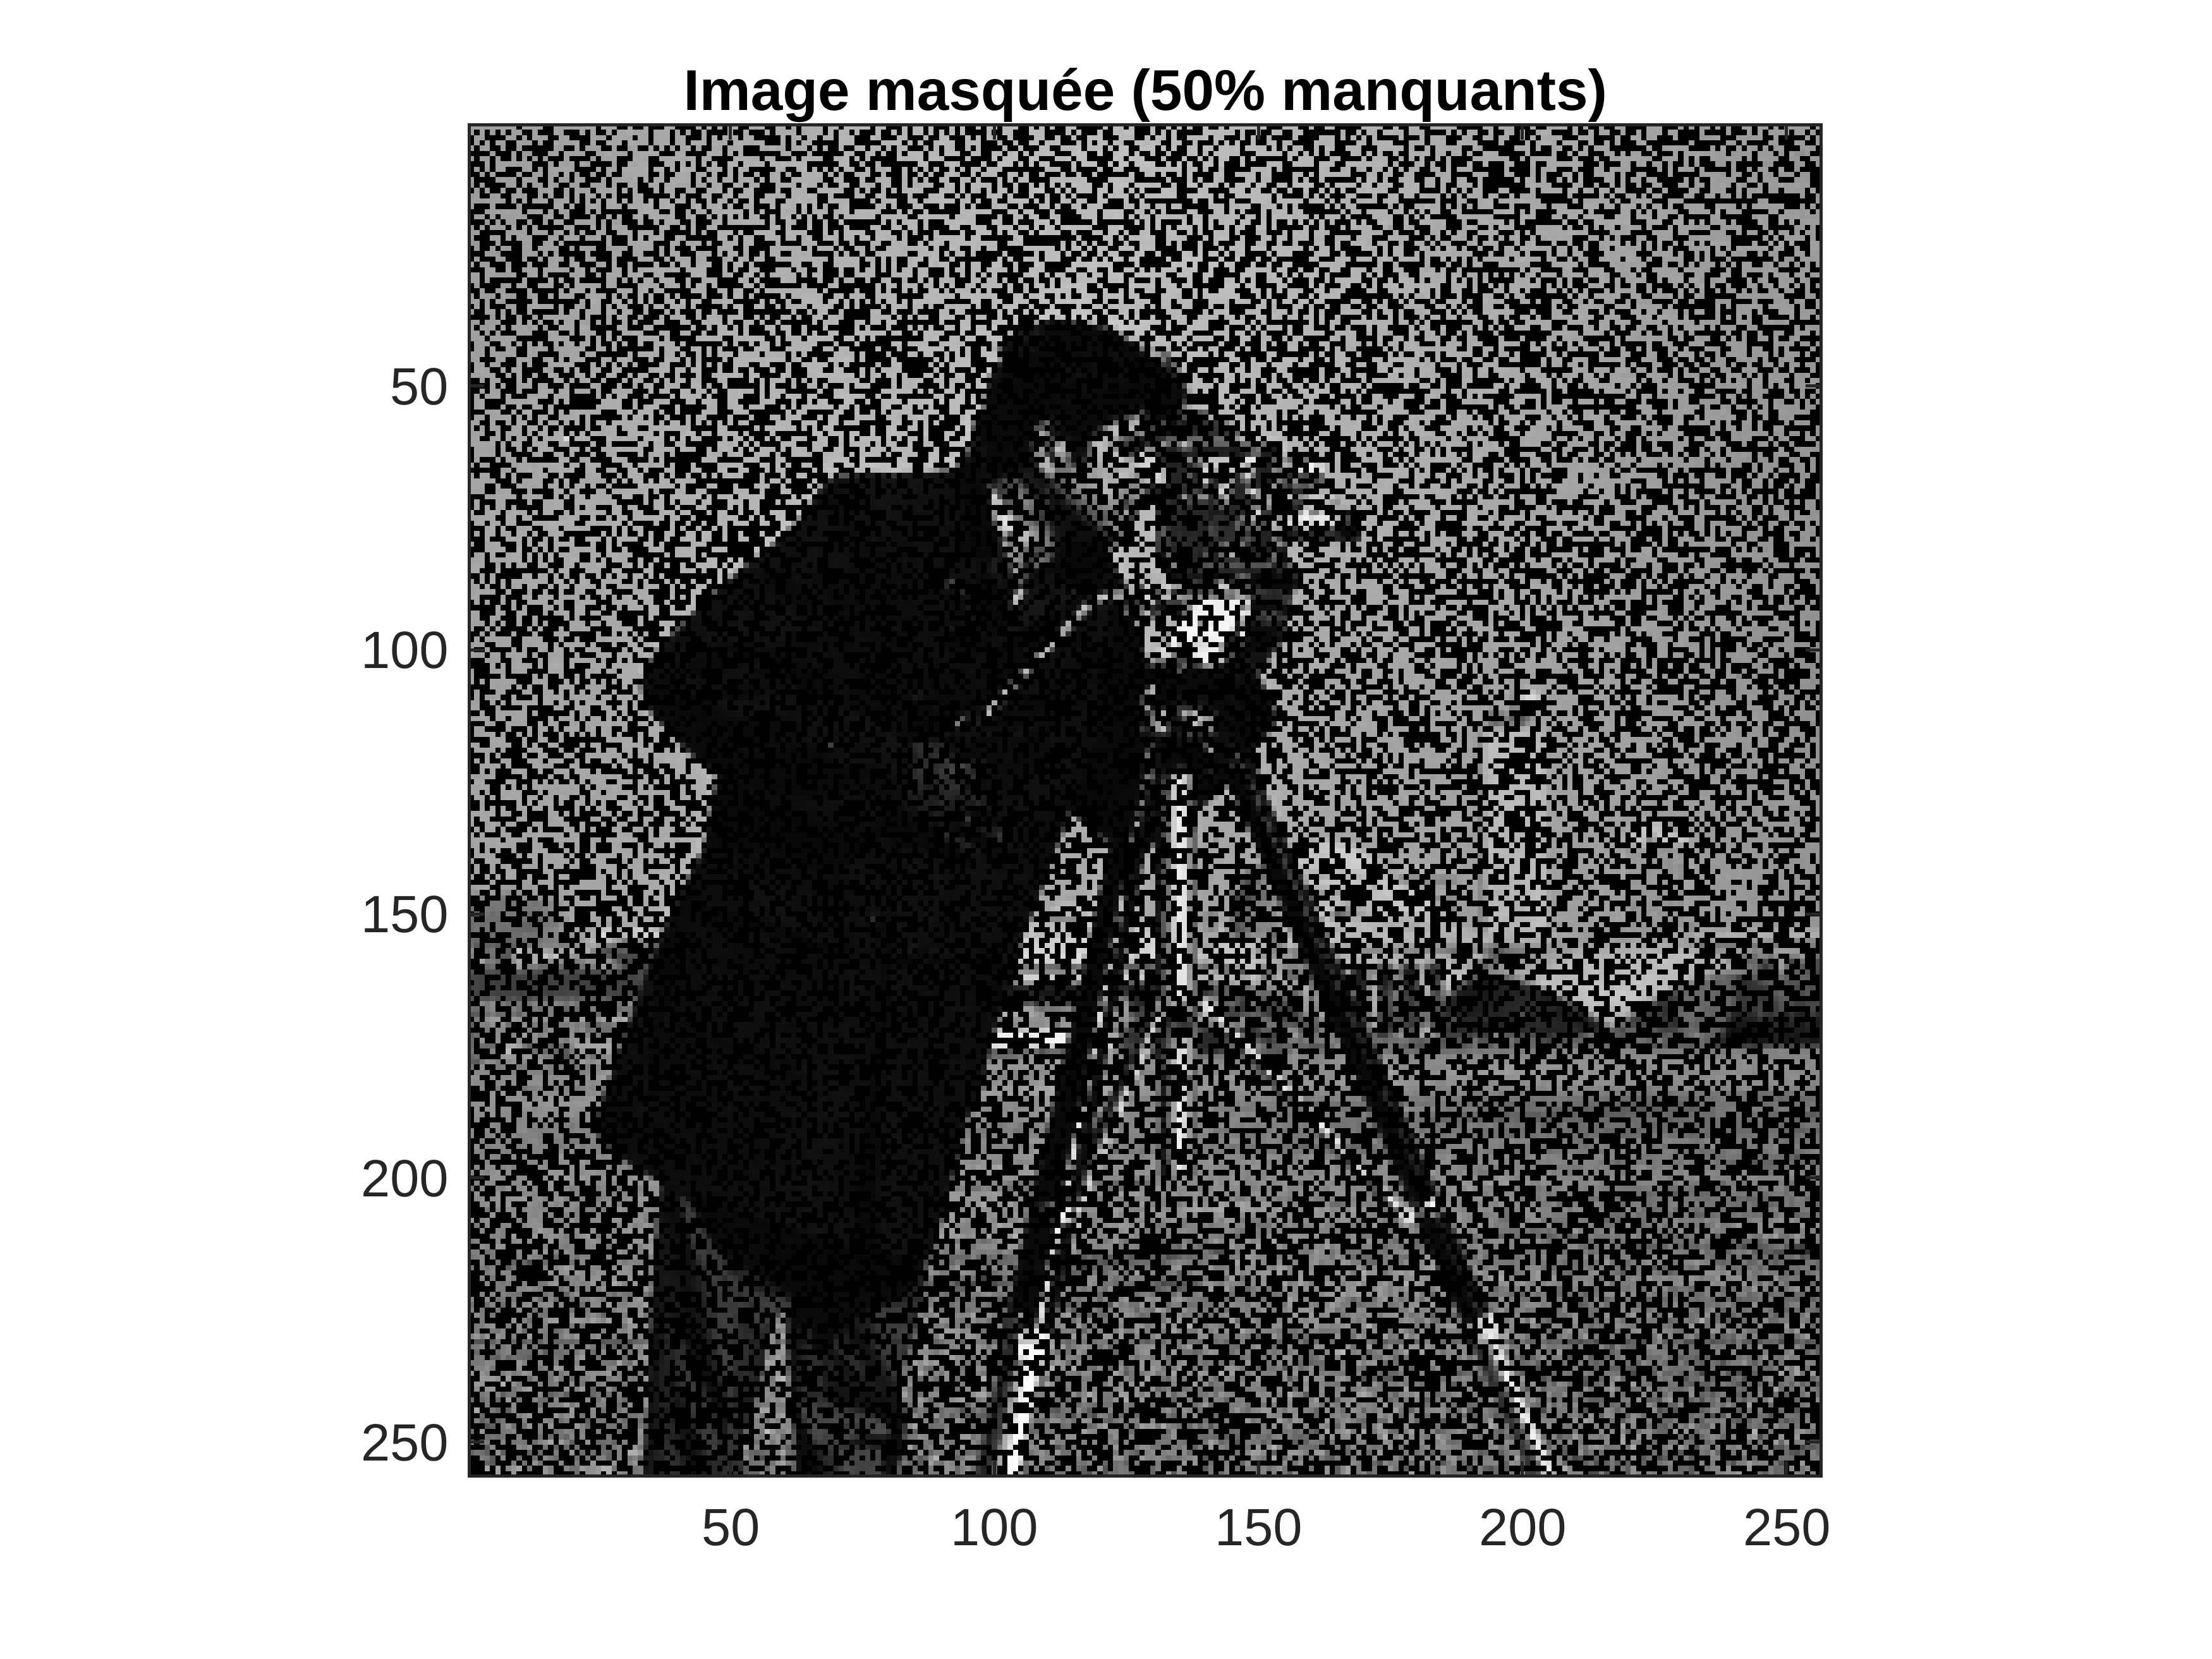

In [12]:
% === 2. Chargement et préparation des données ===

% Charger une image de test
try
    img_vrai = double(imread('/home/thekan/Téléchargements/cameraman.tif'));
catch
    disp("Veuillez télécharger 'cameraman.tif' et la placer dans le dossier.");
    % Alternative :
    % img_vrai = double(rgb2gray(imread('peppers.png')));
    return;
end

img_vrai = img_vrai / max(img_vrai(:)); % Normalisation [0, 1]
[H, W] = size(img_vrai);

% Création du masque (50% de pixels manquants)
seuil_masque = 0.5;
mask = rand(H, W) > seuil_masque;
y_observe = img_vrai .* mask;

% Affichage de l'image masquée
figure;
imagesc(y_observe);
colormap gray;
axis image;
title(['Image masquée (' num2str(seuil_masque*100) '% manquants)']);


 3. Définition du Problème pour UNLocBoX


Nous définissons \$f_1\$ et \$f_2\$.


In [13]:
% Paramètre de régularisation (poids de la TV)
lambda = 0.05;


 Fonction 1 : \$f_1(x) = \\frac{1}{2} ||A(x)-y||_2^2\$ (Lisse)


Ici \$A\$ est l'opérateur de masquage.


\* Opérateur \$A(x) = x \\odot \\text{mask}\$


\* Opérateur Adjoint \$A^T(x) = x \\odot \\text{mask}\$


\* Gradient : \$\\nabla f_1(x) = A^T (A(x) - y)\$


\* Constante (borne) : \$\\beta = ||A||_2^2 = 1\$


In [14]:
% ----- Opérateur A (Masque) -----
op_A = @(x) x .* mask;
op_At = @(x) x .* mask;

% ----- f1 : Terme de fidélité (Lisse) -----
f1.eval = @(x) 0.5 * norm(op_A(x) - y_observe, 'fro')^2;
f1.grad = @(x) op_At(op_A(x) - y_observe);
f1.beta = 1;

disp('f1 (lisse) définie.');

f1 (lisse) définie.


 Fonction 2 : \$f_2(x) = \\lambda ||x||_{TV}\$ (Non\-lisse)


Nous utilisons le proximal de la Variation Totale, `prox_tv`, fourni par UNLocBoX.


In [15]:
% ----- f2 : Terme de régularisation (Non-lisse) -----
% Note : 'norm_tv' est une fonction que nous devons définir
f2.eval = @(x) lambda * norm_tv(x);

param_tv.maxit = 10;
f2.prox = @(x, T) prox_tv(x, lambda * T, param_tv);

disp('f2 (non-lisse) définie.');

f2 (non-lisse) définie.


 4. Résolution du Problème


Nous lançons le solveur, en utilisant l'image masquée `y_observe` comme point de départ \$x_0\$.


In [16]:
% === 4. Résolution du Problème ===

x0 = y_observe; % Point de départ

param.maxit = 100;
param.tol = 1e-4;
param.verbose = 1;

[x_solution, info] = solvep(x0, {f1, f2}, param);

  Prox_TV: obj = 1.090008e+03, rel_obj = 8.030527e-04, TOL_EPS, iter = 7
  Prox_TV: obj = 8.885040e+02, rel_obj = 9.390564e-04, TOL_EPS, iter = 7
  Prox_TV: obj = 6.559590e+02, rel_obj = 9.520392e-04, TOL_EPS, iter = 8
  Prox_TV: obj = 4.279330e+02, rel_obj = 1.134060e-03, MAX_IT, iter = 10
  Prox_TV: obj = 2.538821e+02, rel_obj = 2.534827e-03, MAX_IT, iter = 10
  Prox_TV: obj = 1.524972e+02, rel_obj = 4.606894e-03, MAX_IT, iter = 10
  Prox_TV: obj = 1.121957e+02, rel_obj = 5.880602e-03, MAX_IT, iter = 10
  Prox_TV: obj = 1.016167e+02, rel_obj = 6.101918e-03, MAX_IT, iter = 10
  Prox_TV: obj = 9.707798e+01, rel_obj = 6.142253e-03, MAX_IT, iter = 10
  Prox_TV: obj = 9.286149e+01, rel_obj = 5.487550e-03, MAX_IT, iter = 10
  Prox_TV: obj = 9.034735e+01, rel_obj = 4.848143e-03, MAX_IT, iter = 10
  Prox_TV: obj = 8.952412e+01, rel_obj = 4.672012e-03, MAX_IT, iter = 10
  Prox_TV: obj = 8.933764e+01, rel_obj = 4.646395e-03, MAX_IT, iter = 10
  Prox_TV: obj = 8.923143e+01, rel_obj = 4.592415e-

In [17]:

disp(['Solution trouvée en ' num2str(info.iter) ' itérations.']);

Solution trouvée en 17 itérations.


5. Affichage des résultats


Comparons l'image originale, l'image masquée, et l'image restaurée.



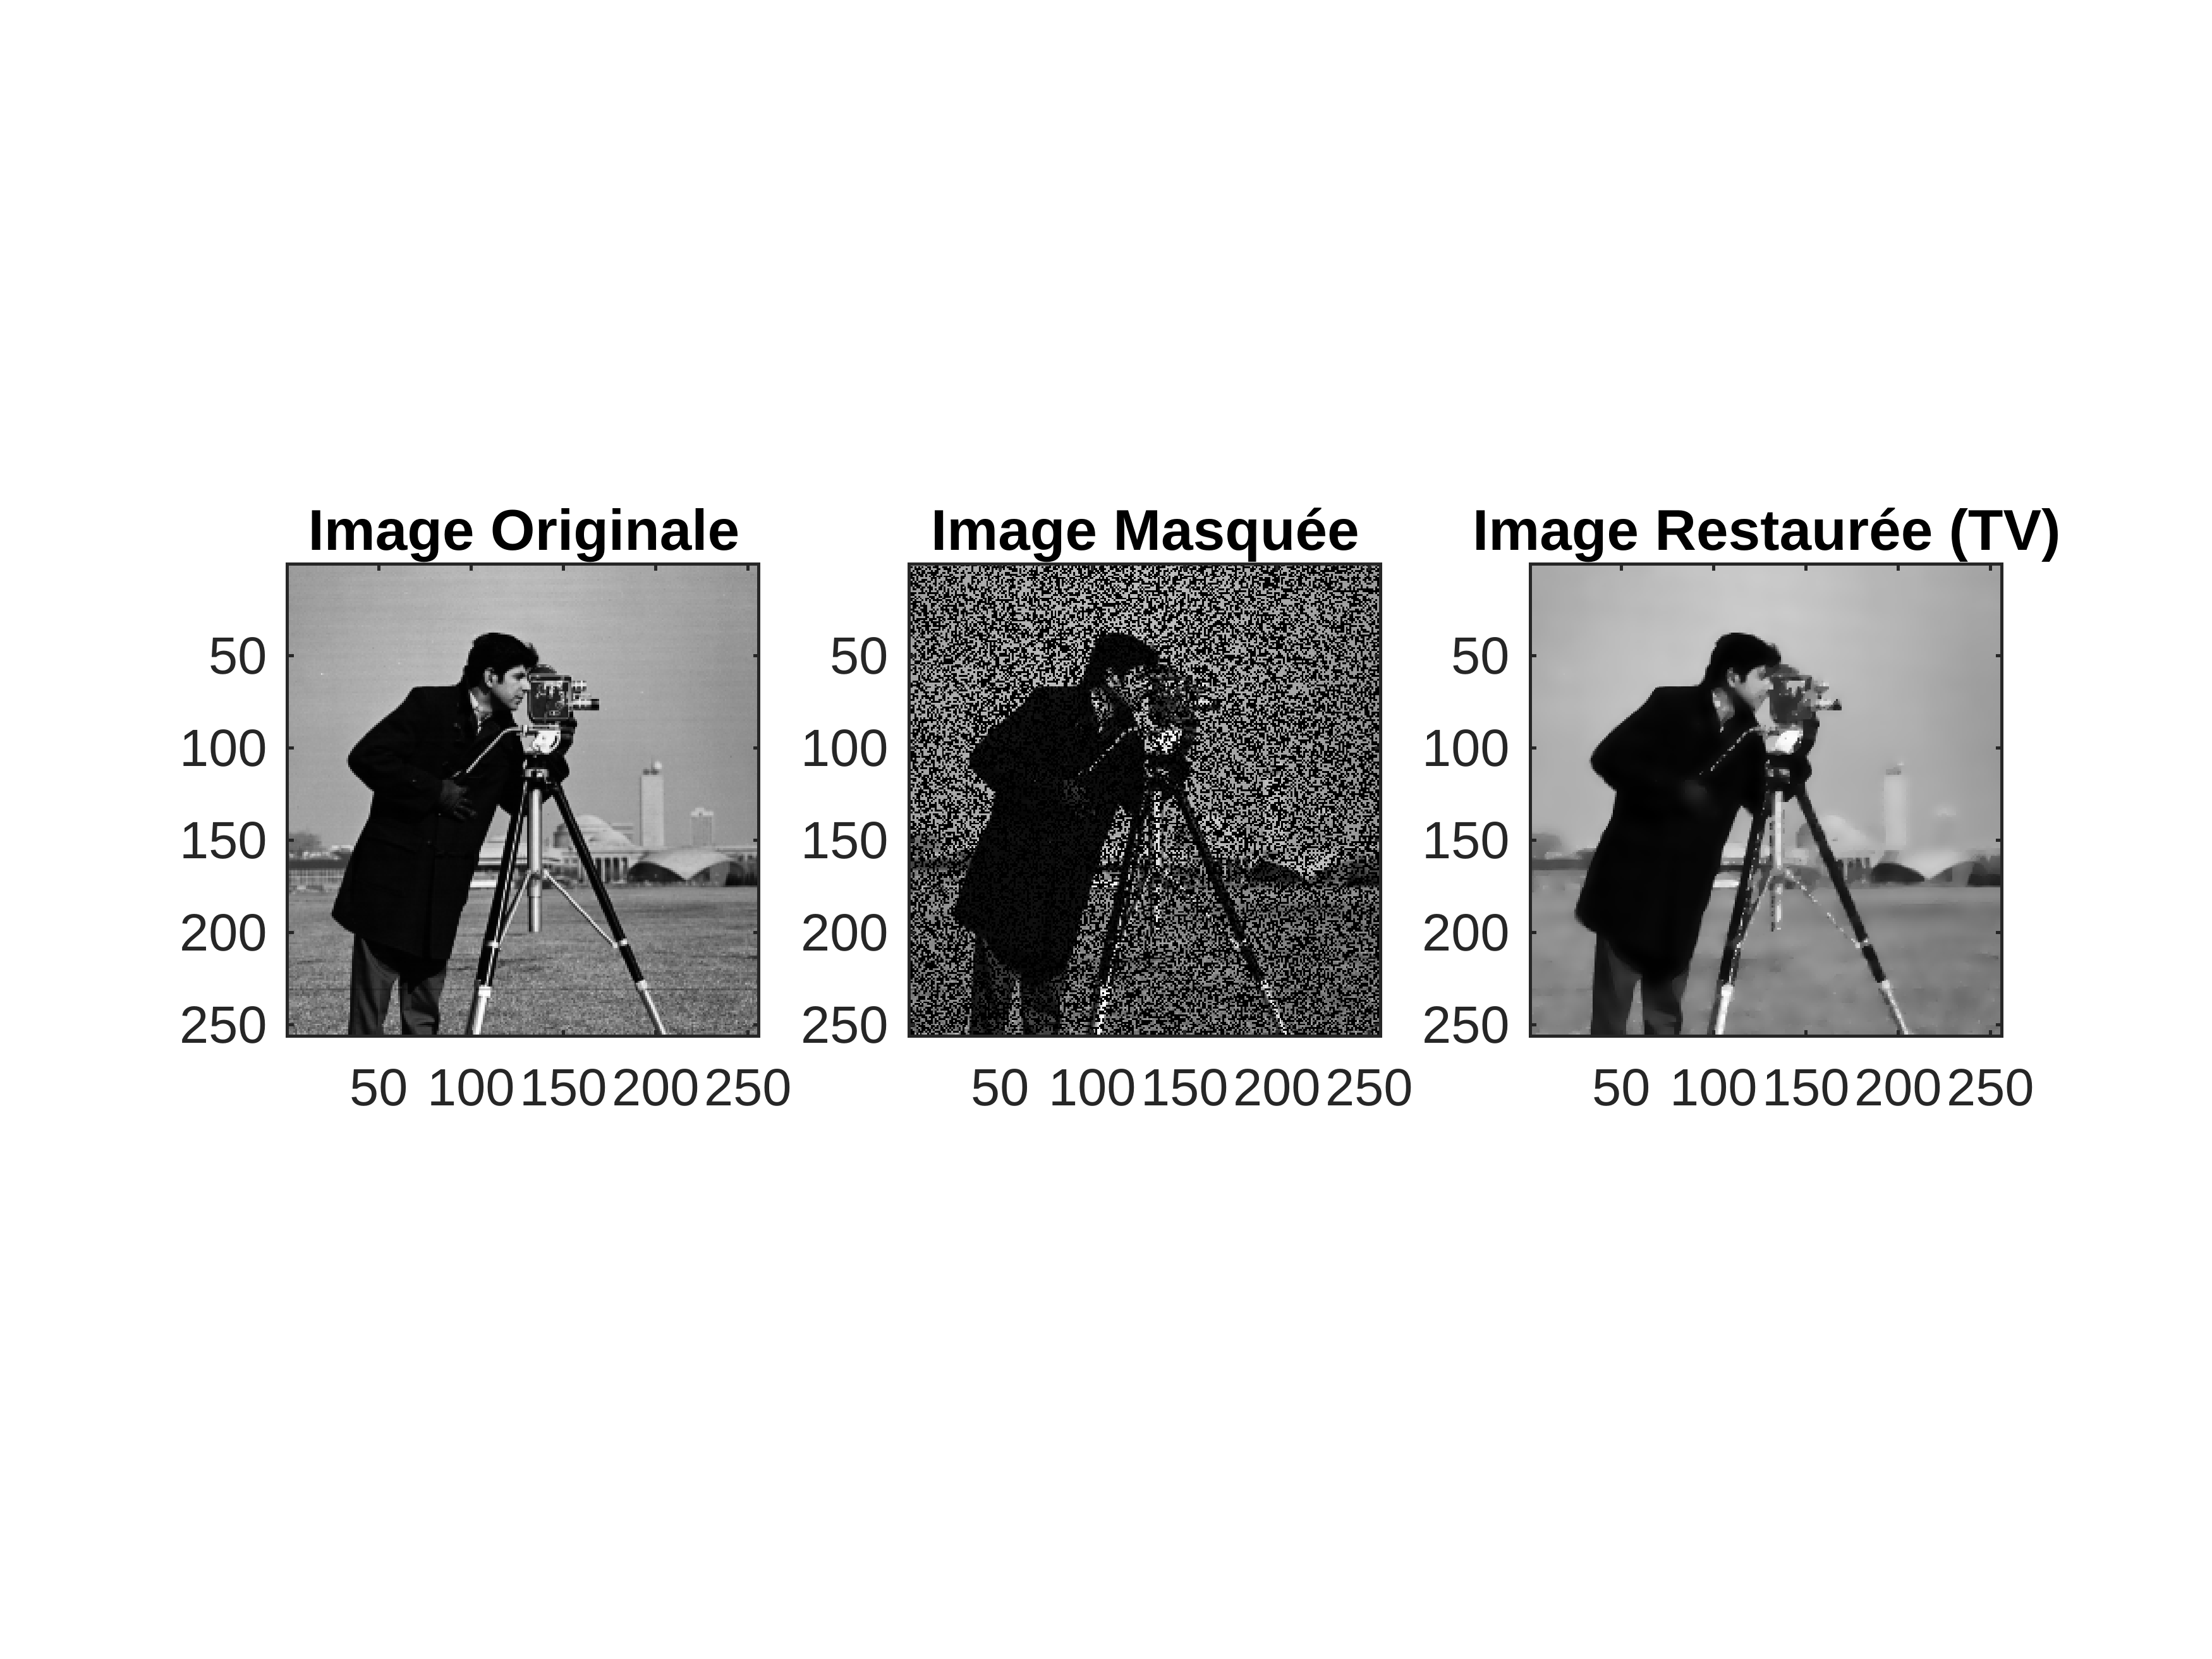

In [18]:
% === 5. Affichage des résultats ===

figure;
subplot(1, 3, 1);
imagesc(img_vrai); axis image; colormap gray;
title('Image Originale');

subplot(1, 3, 2);
imagesc(y_observe); axis image; colormap gray;
title('Image Masquée');

subplot(1, 3, 3);
imagesc(x_solution); axis image; colormap gray;
title('Image Restaurée (TV)');


Fonction Utilitaire


Pour que la cellule `f2.eval` fonctionne, nous devons définir `norm_tv`. Les Live Scripts préfèrent que les fonctions soient à la fin du script.


In [19]:
% === Fonction utilitaire pour f2.eval ===
% (Doit être définie à la fin du Live Script)

function val = norm_tv(img)
    [gx, gy] = gradient(img);
    val = sum(sqrt(gx.^2 + gy.^2), 'all');
end